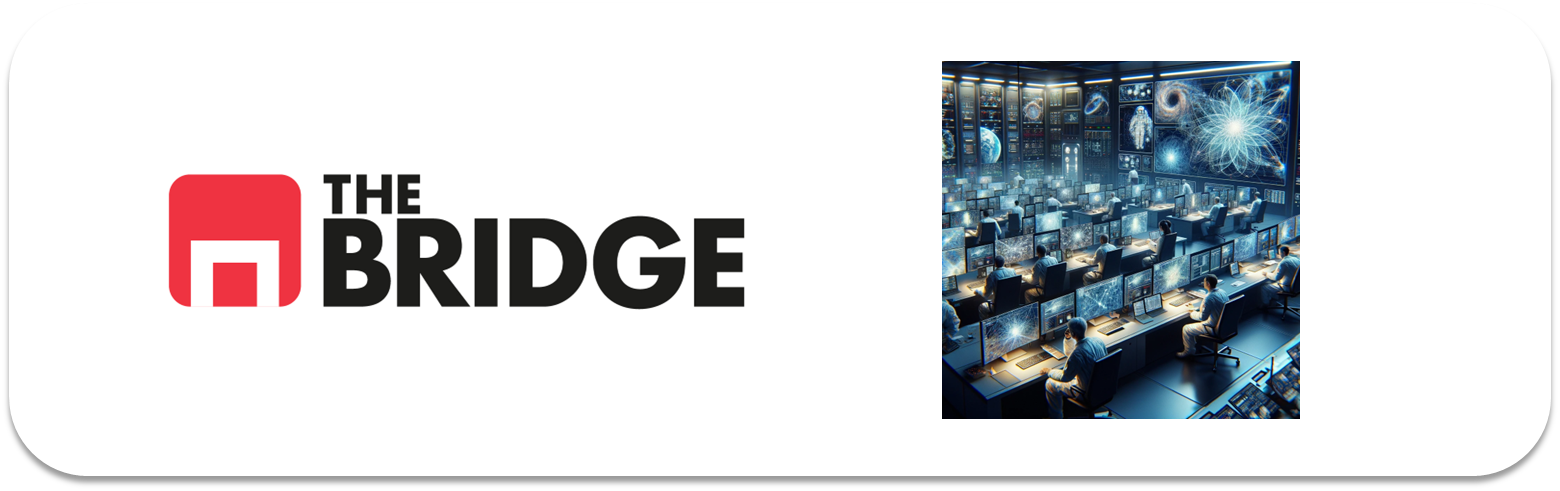

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



In [43]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix




In [44]:
def load_image_data_for_df(folder_path):
    import os, cv2
    images = []
    labels = []
    filenames = []
    
    for file in os.listdir(folder_path):
        if file.endswith(".jpg") or file.endswith(".png"):
            path = os.path.join(folder_path, file)
            img = cv2.imread(path)
            img = cv2.resize(img, (32, 32))
            img = img / 255.0
            
            label = 0 if "dog" in file.lower() else 1
            images.append(img)
            labels.append(label)
            filenames.append(file)
    
    return images, labels, filenames

In [45]:
import pandas as pd

# Recolectamos desde los 4 directorios
all_images = []
all_labels = []
all_files = []

train_dirs = ["github_train_0", "github_train_1", "github_train_2", "github_train_3"]

for d in train_dirs:
    path = os.path.join("data", d)
    imgs, lbls, names = load_image_data_for_df(path)
    all_images.extend(imgs)
    all_labels.extend(lbls)
    all_files.extend(names)

# Creamos el DataFrame
df_train = pd.DataFrame({
    "filename": all_files,
    "label": all_labels
})

# Transformamos etiqueta numérica en texto
df_train["class"] = df_train["label"].map({0: "dog", 1: "cat"})


(4000, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4000 non-null   object
 1   label     4000 non-null   int64 
 2   class     4000 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.9+ KB
None
             label
count  4000.000000
mean      0.500000
std       0.500063
min       0.000000
25%       0.000000
50%       0.500000
75%       1.000000
max       1.000000


C:\Users\sheir\AppData\Local\Temp\ipykernel_28104\1995218284.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x="class", palette="Set2")


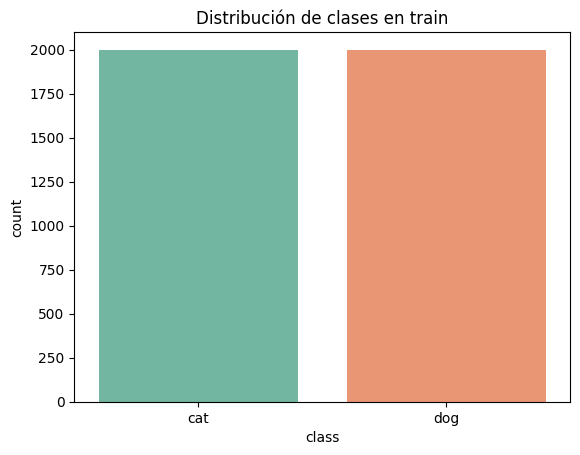

           filename  label class
813    cat.3802.jpg      1   cat
343    cat.2183.jpg      1   cat
3674  dog.11710.jpg      0   dog
1038  cat.10121.jpg      1   cat
3788  dog.11971.jpg      0   dog


In [46]:
print(df_train.shape)
print(df_train.info())
print(df_train.describe())

# Visualización de clases
sns.countplot(data=df_train, x="class", palette="Set2")
plt.title("Distribución de clases en train")
plt.show()

# Mostrar ejemplos de filenames
print(df_train.sample(5))

Tenemos 4000 imágenes con nombre de archivo, etiqueta numérica y clase string. Todos los datos completos y sin NaN. Bien balanceado. El etiquetado está basado en el nombre del archivo. 

Le hago lo mismo a test

In [47]:
# Usamos la función que ya tenemos
test_dir = os.path.join("data", "github_test")
X_test_list, y_test_list, filenames_test = load_image_data_for_df(test_dir)

# Convertimos a arrays
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)

# Creamos el DataFrame para trazabilidad futura
df_test = pd.DataFrame({
    "filename": filenames_test,
    "label": y_test_list,
    "class": ["dog" if l == 0 else "cat" for l in y_test_list]
})

In [48]:
print(df_test.shape)


(1000, 3)


Usamos Keras sobre TensorFlow. Dos bloques convolucionales con activaciones relu

In [49]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Primer bloque convolucional + pooling
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    # Segundo bloque convolucional + pooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Aplanamos y conectamos
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    # Capa de salida: clasificación binaria
    layers.Dense(1, activation='sigmoid')
])

c:\Users\sheir\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [51]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,977 (652.25 KB)

 Trainable params: 166,977 (652.25 KB)

 Non-trainable params: 0 (0.00 B)

Entrenar el modelo con EarlyStopping

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback para detener si no mejora la validación durante 5 épocas
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [53]:
history = model.fit(
    X_train, y_train,
    epochs=110,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/110
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5980 - loss: 0.6792 - val_accuracy: 0.0000e+00 - val_loss: 1.2441
Epoch 2/110
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6384 - loss: 0.6357 - val_accuracy: 0.1375 - val_loss: 1.0152
Epoch 3/110
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6759 - loss: 0.6047 - val_accuracy: 0.4112 - val_loss: 0.8233
Epoch 4/110
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7286 - loss: 0.5486 - val_accuracy: 0.3487 - val_loss: 0.9328
Epoch 5/110
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7181 - loss: 0.5435 - val_accuracy: 0.5925 - val_loss: 0.7405
Epoch 6/110
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7658 - loss: 0.5048 - val_accuracy: 0.5675 - val_loss: 0.7625
Epoch 7/110
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7771 - loss: 0.4902 - val_accuracy: 0.6975 - val_loss: 0.5972
Epoch 8/110
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7959 - loss: 0.4518

Visualizo el historial:

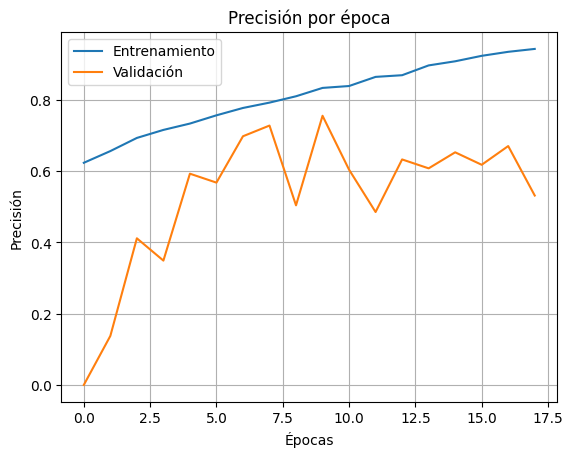

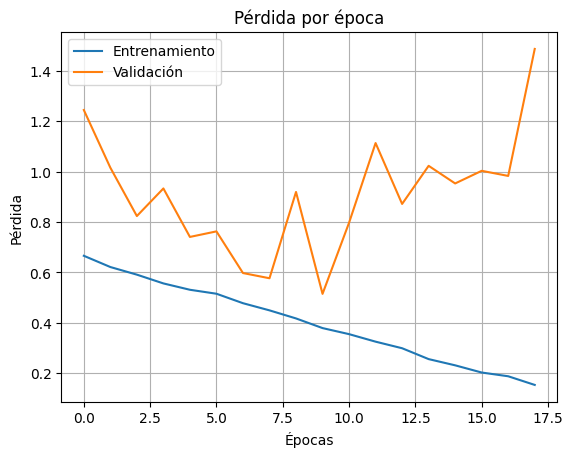

In [54]:
import matplotlib.pyplot as plt

# Gráfico de precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

# Gráfico de pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

Evalúo sobre test

In [55]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"📉 Pérdida en test: {loss:.4f}")
print(f"🎯 Precisión en test: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7481 - loss: 0.5182
📉 Pérdida en test: 0.5160
🎯 Precisión en test: 0.7580


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\sheir\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


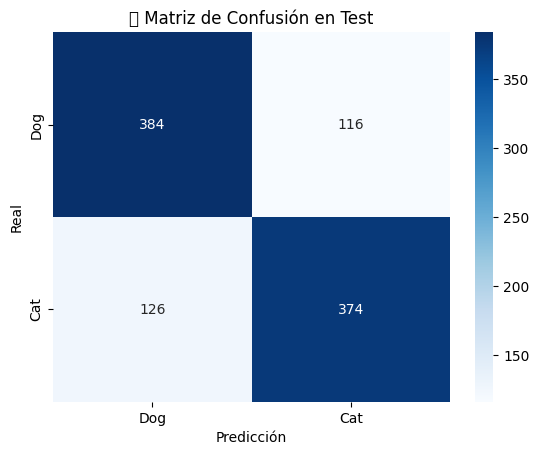

              precision    recall  f1-score   support

         Dog       0.75      0.77      0.76       500
         Cat       0.76      0.75      0.76       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



In [56]:
# Predicciones
y_pred_probs = model.predict(X_test).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)  # Umbral 0.5

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Dog", "Cat"], yticklabels=["Dog", "Cat"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("📊 Matriz de Confusión en Test")
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=["Dog", "Cat"]))

104 perros se predijeron como gatos y 127 gatos se predijeron como perros. El modelo tiene ciertas dificultades clasificando gatos correctamente, más que con perros.
Buen equilibrio entre clases y buen punto para detectar cuáles imágenes engañan al sistema.

Candidatas para reforzar el CAPTCHA

In [57]:
# Volvemos a hacer las predicciones de probabilidad
y_pred_probs = model.predict(X_test).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# Creamos DataFrame base con info del test
df_eval = df_test.copy()
df_eval["y_true"] = y_test
df_eval["y_pred"] = y_pred
df_eval["prob"] = y_pred_probs

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [58]:
# Perros clasificados como gatos (dog → 0, predicho como 1)
dogs_misclassified = df_eval[(df_eval["y_true"] == 0) & (df_eval["y_pred"] == 1)]

# Gatos clasificados como perros (cat → 1, predicho como 0)
cats_misclassified = df_eval[(df_eval["y_true"] == 1) & (df_eval["y_pred"] == 0)]

In [59]:
# Perros mal clasificados con alta probabilidad de ser perros
dogs_confused = dogs_misclassified.copy()
dogs_confused["conf_perro"] = 1 - dogs_confused["prob"]  # Confianza en clase 0
dogs_confused = dogs_confused.sort_values(by="conf_perro", ascending=False)

# Gatos mal clasificados con alta probabilidad de ser gatos
cats_confused = cats_misclassified.copy()
cats_confused["conf_gato"] = cats_confused["prob"]  # Confianza en clase 1
cats_confused = cats_confused.sort_values(by="conf_gato", ascending=False)

In [60]:
# Selección del 10% superior
n_dogs = int(len(dogs_confused) * 0.10)
n_cats = int(len(cats_confused) * 0.10)

dogs_selected = dogs_confused.head(n_dogs)
cats_selected = cats_confused.head(n_cats)

# Concatenamos resultados finales
df_dificiles = pd.concat([dogs_selected, cats_selected]).reset_index(drop=True)

Top 10

C:\Users\sheir\AppData\Local\Temp\ipykernel_28104\3665881524.py:12: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\sheir\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


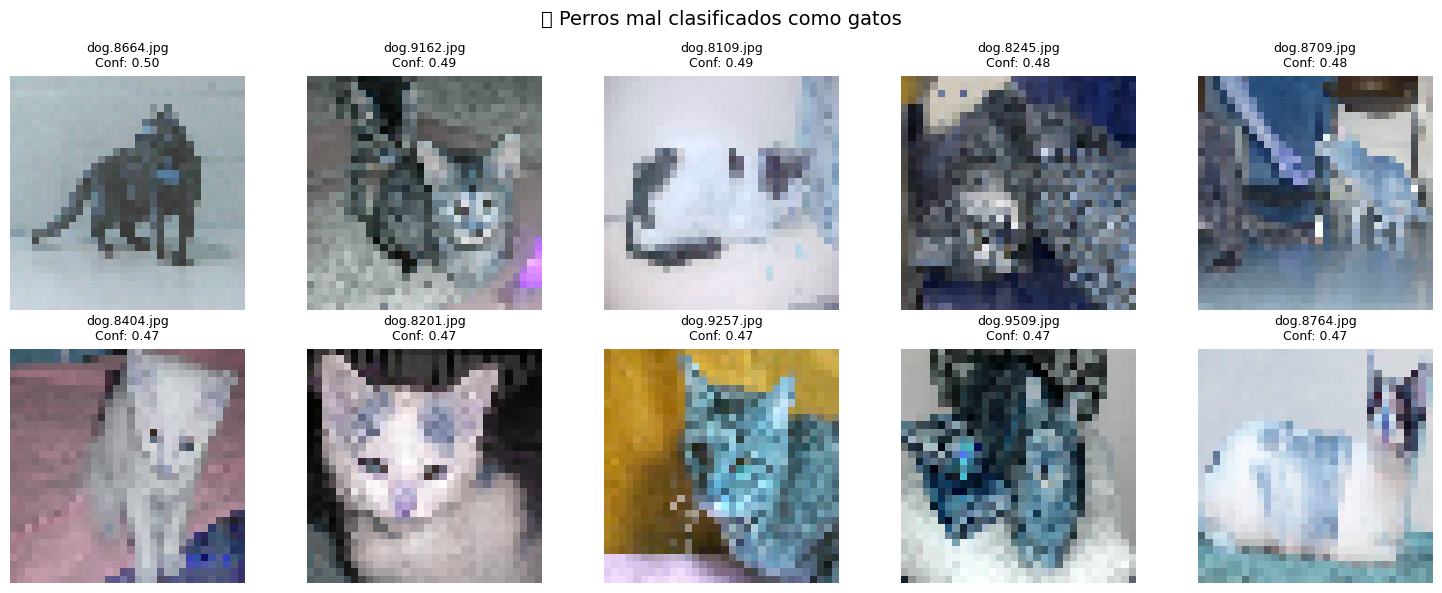

In [61]:
plt.figure(figsize=(15, 6))
for i in range(10):
    img = X_test[df_dificiles[df_dificiles["y_true"] == 0].iloc[i].name]
    fname = df_dificiles[df_dificiles["y_true"] == 0].iloc[i]["filename"]
    conf = df_dificiles[df_dificiles["y_true"] == 0].iloc[i]["conf_perro"]
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"{fname}\nConf: {conf:.2f}", fontsize=9)
    plt.axis("off")
plt.suptitle("🐶 Perros mal clasificados como gatos", fontsize=14)
plt.tight_layout()
plt.show()

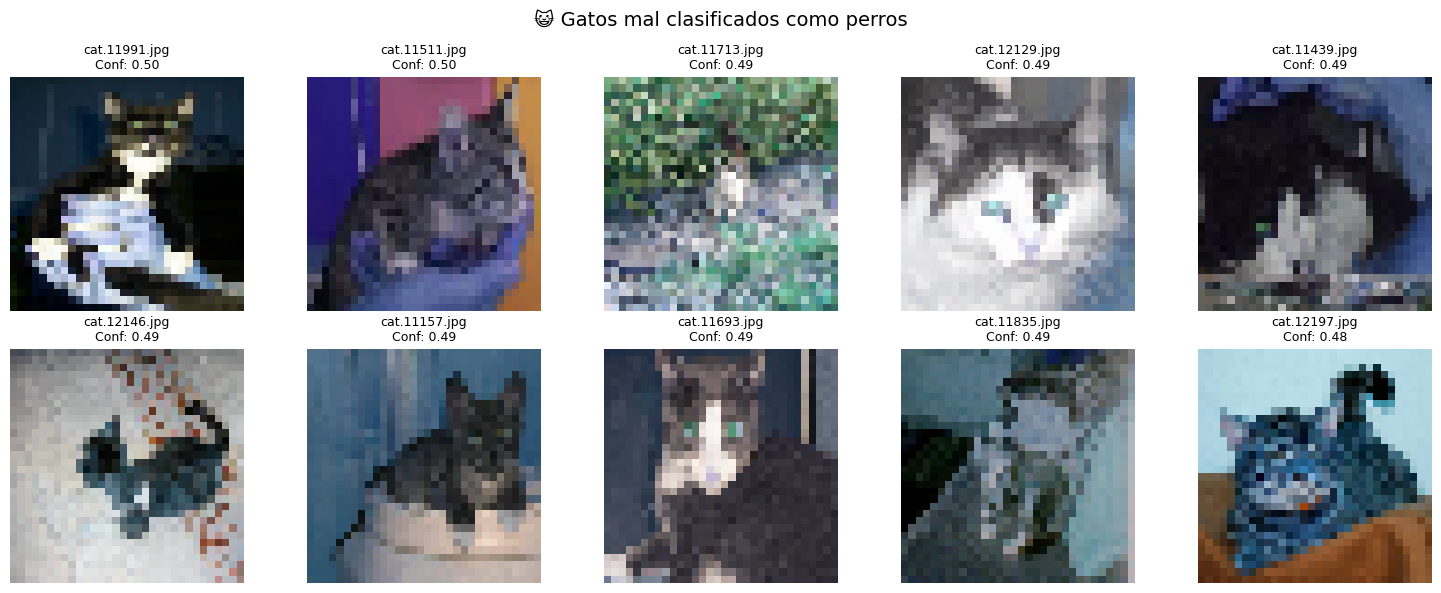

In [62]:
plt.figure(figsize=(15, 6))
for i in range(10):
    img = X_test[df_dificiles[df_dificiles["y_true"] == 1].iloc[i].name]
    fname = df_dificiles[df_dificiles["y_true"] == 1].iloc[i]["filename"]
    conf = df_dificiles[df_dificiles["y_true"] == 1].iloc[i]["conf_gato"]
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"{fname}\nConf: {conf:.2f}", fontsize=9)
    plt.axis("off")
plt.suptitle("😺 Gatos mal clasificados como perros", fontsize=14)
plt.tight_layout()
plt.show()